# **NFT Price Prediction using Deep Learning**
---




# **Overview of Notebook:**

- Section 1 - Introduction
- Section 2 - Data Extraction
- Section 3 - Exploratory Data Analysis
- Section 4 - Data Cleaning and Data Pre-Processing
- Section 5 - Baseline Model Approach



# **Section 1 - Introduction**

This project utilizes deep learning to predict NFT prices, addressing the challenge of their unique, volatile nature. By analyzing historical transaction data and metadata from NFT platforms, we aim to develop predictive models that offer insights and aid in investment decisions. This approach combines data extraction, exploratory analysis, and advanced modeling techniques to enhance understanding of NFT market dynamics.


# **Section 2 - Data Extraction Steps**

- Developed custom SQL queries on Dune Analytics to extract detailed NFT transaction data, resulting in the creation of the nft_dune_extraction.csv file.
- Additional data on NFT traits and rarity was obtained via the OpenSea API, which was compiled into the nft_opensea_extraction.csv file.
- These datasets are crucial for our analysis, allowing us to build and refine predictive models for NFT prices.
- For further insights into the extraction methods used, you can explore the query used on Dune Analytics.

# **Section 3 - Exploratory Data Analysis**

#Loading and Exploring Datasets

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
dune_df = pd.read_csv('data/nft_dune_extraction.csv')
opensea_df = pd.read_csv('data/nft_opensea_extraction.csv')

# Display basic information and the first few rows to understand the structure
print(dune_df.info())
print(dune_df.head())
print(opensea_df.info())
print(opensea_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43547 entries, 0 to 43546
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       43547 non-null  int64  
 1   project          43547 non-null  object 
 2   version          43547 non-null  object 
 3   block_date       43547 non-null  object 
 4   block_month      43547 non-null  object 
 5   block_time       43547 non-null  object 
 6   token_id         43547 non-null  int64  
 7   collection       43547 non-null  object 
 8   amount_usd       43547 non-null  object 
 9   token_standard   43547 non-null  object 
 10  trade_type       43547 non-null  object 
 11  number_of_items  43547 non-null  object 
 12  trade_category   43547 non-null  object 
 13  evt_type         43547 non-null  object 
 14  amount_original  43547 non-null  object 
 15  currency_symbol  43547 non-null  object 
 16  tx_hash          43547 non-null  object 
 17  volume_eth  

# Descriptive statistics and Data quality

In [3]:
# Descriptive statistics for both datasets
print(dune_df.describe())
print(opensea_df.describe())

# Check for missing values in both datasets
print(dune_df.isnull().sum())
print(opensea_df.isnull().sum())

         Unnamed: 0      token_id    volume_eth  price_p5_eth  price_min_eth  \
count  43547.000000  43547.000000  43547.000000  43547.000000   4.354700e+04   
mean   21773.000000   5115.243989   2546.357086     30.138966   2.663708e+01   
std    12571.080423   2854.365326   3056.694344     30.579966   2.949600e+01   
min        0.000000      5.000000      0.160000      0.000002   1.000000e-18   
25%    10886.500000   2733.000000    676.827431      1.390000   3.200000e-01   
50%    21773.000000   5105.000000   1423.866000     26.290000   1.733333e+01   
75%    32659.500000   7583.000000   3014.270821     48.850000   4.550010e+01   
max    43546.000000   9998.000000  17273.253910    149.000000   1.390000e+02   

       price_max_eth  
count   43547.000000  
mean       83.306864  
std       111.887707  
min         0.160000  
25%        21.000000  
50%        50.500000  
75%       100.000000  
max      1080.690000  
        Unnamed: 0     token_id  rarity_rank  Background_count    Hat_co

# Visualizing Distribution of Key Features

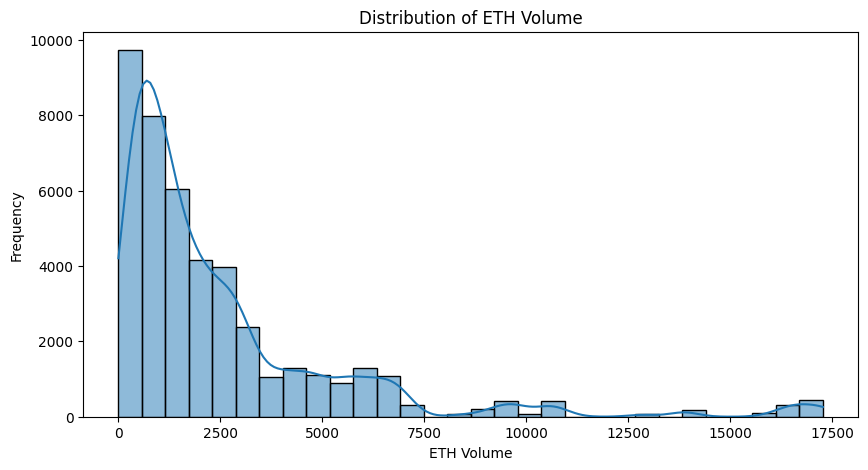

In [4]:
# Histograms for key numerical features
plt.figure(figsize=(10, 5))
sns.histplot(dune_df['volume_eth'], bins=30, kde=True)
plt.title('Distribution of ETH Volume')
plt.xlabel('ETH Volume')
plt.ylabel('Frequency')
plt.show()

# Convert trade price to numeric and plot
dune_df['trade_price'] = pd.to_numeric(dune_df['amount_original'], errors='coerce')


# Analysis of Categorical Data

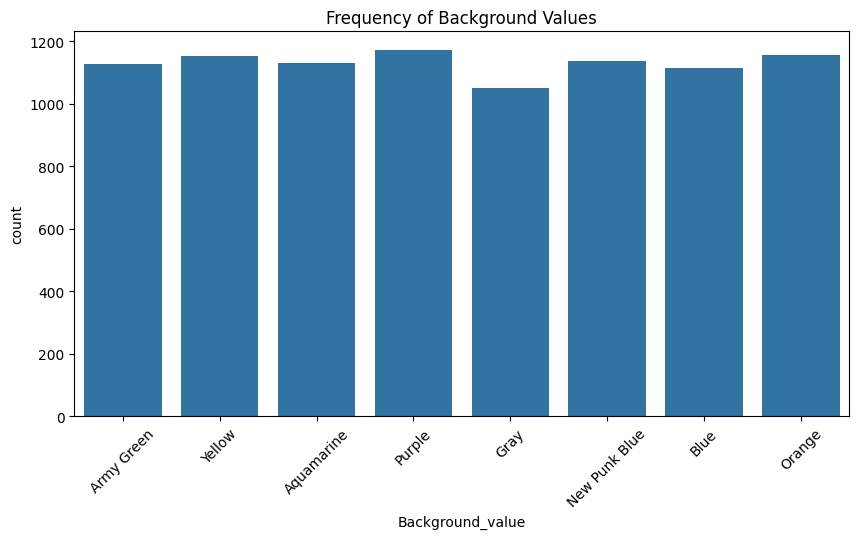

In [6]:
# Count plots for categorical traits from OpenSea dataset
plt.figure(figsize=(10, 5))
sns.countplot(data=opensea_df, x='Background_value')
plt.title('Frequency of Background Values')
plt.xticks(rotation=45)
plt.show()

# Advanced Visualizations

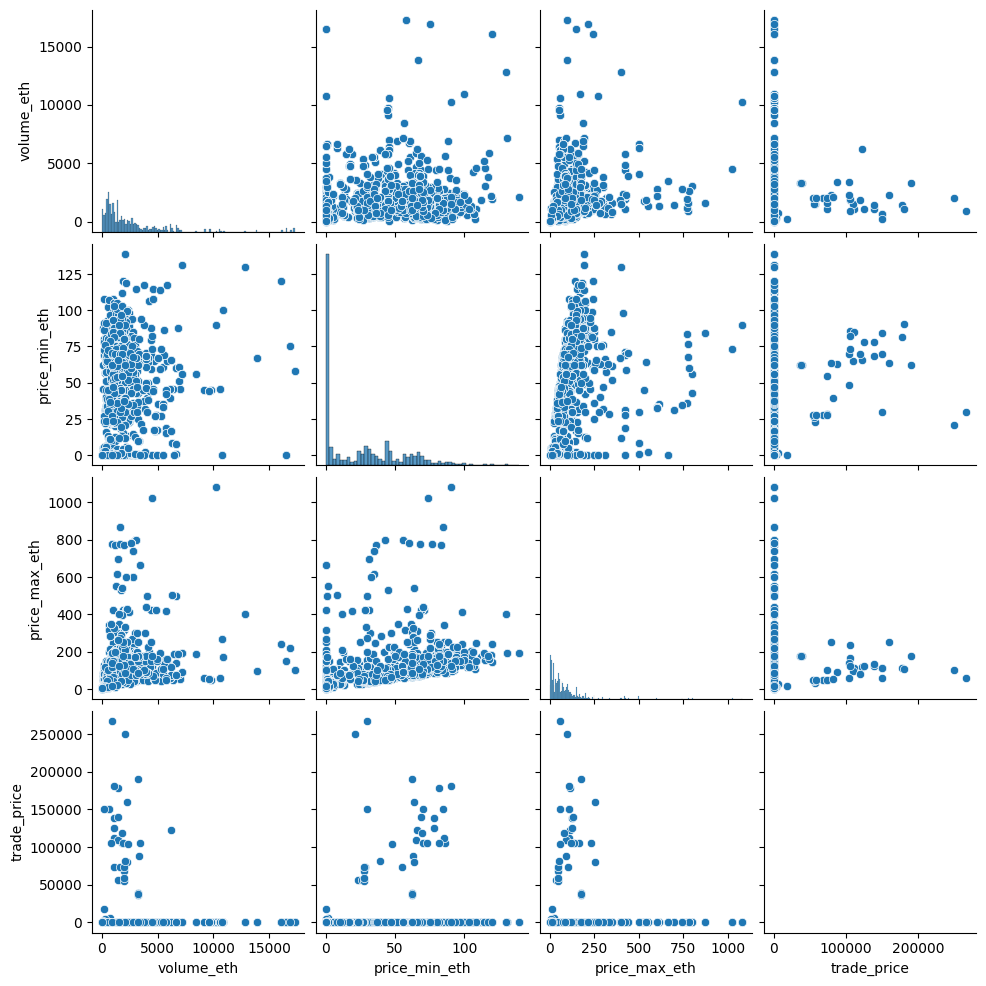

In [7]:
# Pair plot for selected features to visualize the relationships
sns.pairplot(dune_df[['volume_eth', 'price_min_eth', 'price_max_eth', 'trade_price']])
plt.show()

# **Section 4 - Data Cleaning**

In [8]:
import numpy as np
import pandas as pd


# Load Dune Data

In [9]:
df = pd.read_csv("data/nft_dune_extraction.csv", index_col=0)

# Data Cleaning and Preparation


In [10]:
df.rename(columns={'amount_original': 'trade_price'}, inplace=True)
df = df[df['trade_price'] != '<nil>'].copy()  # Ensure it's a copy after filtering
df['trade_price'] = df['trade_price'].astype(float)
df['block_time'] = pd.to_datetime(df['block_time'])
df['block_date'] = pd.to_datetime(df['block_date'])
df['block_month'] = pd.to_datetime(df['block_month'])
df = df[(df['trade_price'] <= df['price_max_eth']) & (df['trade_price'] >= df['price_min_eth'])].copy()

# Properly handle groupby to avoid SettingWithCopyWarning
# Create a new DataFrame to hold groupby results
last_trade_price = df.groupby('token_id')['trade_price'].shift(1)
last_trade_time = df.groupby('token_id')['block_time'].shift(1)

# Safely assign back to df
df.loc[:, 'last_trade_price'] = last_trade_price
df.loc[:, 'last_trade_time'] = last_trade_time
df.loc[:, 'last_trade_timediff'] = (df['block_time'] - df['last_trade_time']).dt.total_seconds() / 86400

In [11]:
# Creating lagged columns for market price/volume data
lag_columns = ['volume_eth', 'price_p5_eth', 'price_max_eth', 'price_min_eth']
daily_aggregated = df.groupby('block_date')[lag_columns].mean().reset_index()
for col in lag_columns:
  daily_aggregated[col + '_lag1'] = daily_aggregated[col].shift(1)

# Merging daily aggregated data
df = df.merge(
daily_aggregated[['block_date'] + [col + '_lag1' for col in lag_columns]],
on='block_date',
how='left'
)

df['trade_price_log'] = np.log(df['trade_price'])

#Load Opensea Data

In [12]:
traits_df = pd.read_csv("data/nft_opensea_extraction.csv", index_col=0)

In [13]:
# Format optional traits
optional_traits = {}
for i, v in traits_df.isna().sum().items():
    if v > 0:
        trait = i.split("_")[0]
        optional_traits[trait] = v

for trait, count in optional_traits.items():
    traits_df[trait+"_value"] = traits_df[trait+"_value"].fillna("Empty")
    traits_df[trait+"_count"] = traits_df[trait+"_count"].fillna(count).astype(int)

In [14]:
# Merge cleaned data with traits data
cleaned = df.merge(traits_df, on='token_id', how='left')
cleaned.to_csv("data/nft_cleaned_data.csv")

# Visualization

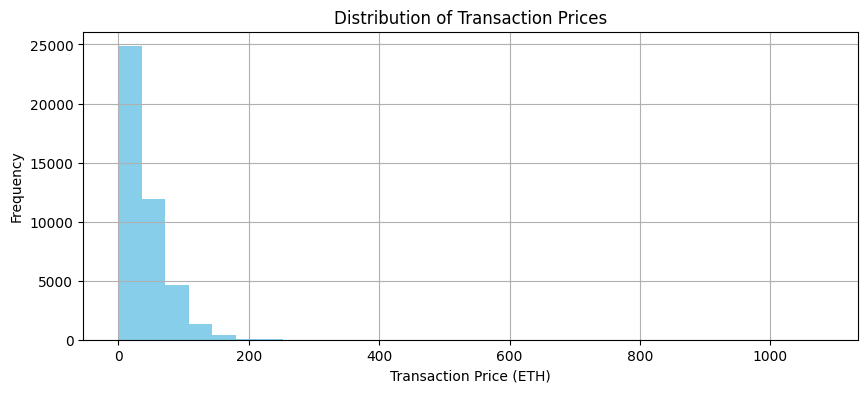

In [15]:
plt.figure(figsize=(10, 4))
plt.hist(df['trade_price'], bins=30, color='skyblue')
plt.title('Distribution of Transaction Prices')
plt.xlabel('Transaction Price (ETH)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# **Section 5 - Baseline Models**

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Load and Prepare Data

In [17]:
file_path = "data/nft_cleaned_data.csv"
df = pd.read_csv(file_path, index_col=0)
df.head()

,project,version,block_date,block_month,block_time,token_id,collection,amount_usd,token_standard,trade_type,...,Mouth_value,Mouth_count,Eyes_value,Eyes_count,Fur_value,Fur_count,Clothes_value,Clothes_count,Earring_value,Earring_count
0,x2y2,v1,2023-01-22,2023-01-01,2023-01-22 00:30:23+00:00,5,Bored Ape Yacht Club,317355.814,erc721,secondary,...,Dumbfounded,505,X Eyes,243,Brown,1370,Bayc T Red,140,Empty,6383
1,opensea,v1,2021-06-21,2021-06-01,2021-06-21 15:56:28+00:00,6,Bored Ape Yacht Club,19761.700,erc721,Single Item Trade: Fixed price,...,Bored,2272,Crazy,407,Cream,636,Tweed Suit,141,Empty,6383
2,opensea,v1,2021-12-22,2021-12-01,2021-12-22 19:16:09+00:00,6,Bored Ape Yacht Club,251182.890,erc721,Single Item Trade: Fixed price,...,Bored,2272,Crazy,407,Cream,636,Tweed Suit,141,Empty,6383
3,opensea,v3,2022-07-03,2022-07-01,2022-07-03 16:40:36+00:00,6,Bored Ape Yacht Club,93910.130,erc721,single item trade,...,Bored,2272,Crazy,407,Cream,636,Tweed Suit,141,Empty,6383
4,opensea,v3,2022-10-21,2022-10-01,2022-10-21 00:56:23+00:00,8,Bored Ape Yacht Club,141705.300,erc721,single item trade,...,Bored,2272,Robot,350,Zombie,302,Empty,1690,Gold Stud,439


# Feature Configuration

In [18]:
feature_columns = {
    "market" : ['volume_eth', 'price_p5_eth_lag1', 'price_max_eth_lag1', 'price_min_eth_lag1'],
    "traits_rarity" : ['rarity_rank', 'Background_count', 'Mouth_count', 'Eyes_count', 'Fur_count', 'Hat_count', 'Clothes_count', 'Earring_count'],
    "last_trade" : ['last_trade_timediff', 'last_trade_price'],
}

outcome_columns = {
    'trade_price' : 'trade_price',
    'amount_usd' : 'amount_usd',
    'trade_price_log' : 'trade_price_log'
}

# Model Outcomes

In [19]:
def df_to_xy(df, X_cols, y_col):

    # fetch variables of interest, drop missing values
    data = df.copy()
    n = len(data)
    data = data.dropna(subset=X_cols+[y_col])
    print(f"Number of observations: {len(data)}/{n}")

    X = data[X_cols]
    y = data[y_col]

    return X, y

# Principal Component Analysis (PCA)

In [20]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def feature_PCA(df, X_cols, y_col, plot=False):
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA())
    ])

    X,y = df_to_xy(df,X_cols,y_col)

    X_PCA = pipe.fit_transform(X)

    if plot:
        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(projection='3d')
        ax.scatter(X_PCA[:,0], X_PCA[:,1], X_PCA[:,2], c=y)
        ax.set_xlabel("PCA0")
        ax.set_ylabel("PCA1")
        ax.set_zlabel("PCA2")
        ax.set_title("PCA space")
        plt.show()

    return X_PCA


# Benchmark models
- Linear regression: OLS, Ridge, Lasso
- Tree-based model: Random Forest, gradient boosting




In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def benchmark_models(df, X_cols, y_col, models=None):
    if models is None:
        models = ['ols', 'lasso', 'ridge', 'rf', 'gb']

    X, y = df_to_xy(df, X_cols, y_col)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    results = {}

    # Dictionary to store models for easier access and looping
    model_dict = {
        'ols': LinearRegression(),
        'lasso': Lasso(random_state=42),
        'ridge': Ridge(),
        'rf': RandomForestRegressor(random_state=42),
        'gb': GradientBoostingRegressor(random_state=42)
    }

    for model_name, model in model_dict.items():
        try:
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            mse = mean_squared_error(y_test, predictions)
            mae = mean_absolute_error(y_test, predictions)
            results[model_name] = {'MSE': mse, 'MAE': mae}
            print(f"{model_name.upper()} - MSE: {mse:.3f}, MAE: {mae:.3f}")
        except Exception as e:
            print(f"Error processing {model_name}: {str(e)}")

    return results



# Example Application of Models

Number of observations: 34362/43402


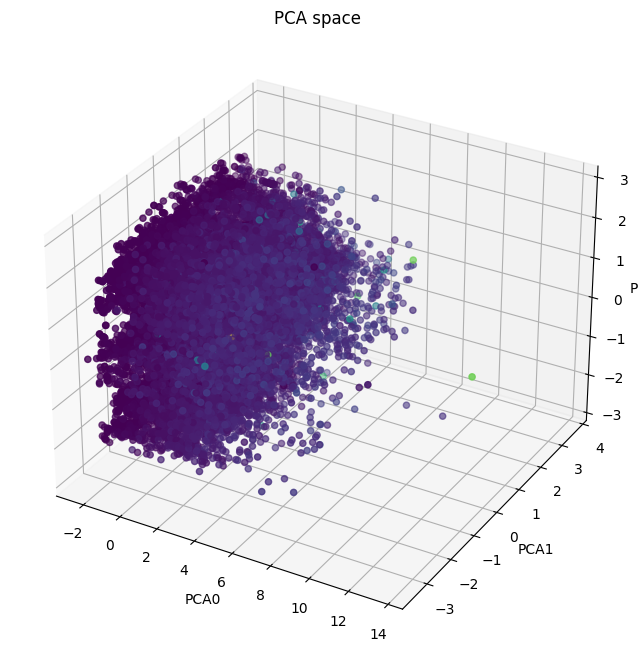

Model 1
Outcome variable: trade_price
Explanatory variable set: X_1
Number of observations: 34362/43402
OLS - MSE: 486.630, MAE: 8.183
LASSO - MSE: 510.424, MAE: 8.042
RIDGE - MSE: 486.631, MAE: 8.182
RF - MSE: 273.088, MAE: 4.003
GB - MSE: 256.838, MAE: 5.309


Model 2
Outcome variable: trade_price
Explanatory variable set: X_2
Number of observations: 43401/43402
OLS - MSE: 416.310, MAE: 7.204
LASSO - MSE: 433.559, MAE: 7.075
RIDGE - MSE: 416.315, MAE: 7.204
RF - MSE: 196.801, MAE: 3.566
GB - MSE: 205.541, MAE: 4.796


Model 3
Outcome variable: trade_price
Explanatory variable set: X_3
Number of observations: 34362/43402
OLS - MSE: 863.449, MAE: 16.774
LASSO - MSE: 869.950, MAE: 17.017
RIDGE - MSE: 863.451, MAE: 16.774
RF - MSE: 357.675, MAE: 6.751
GB - MSE: 410.575, MAE: 8.161


Model 4
Outcome variable: trade_price_log
Explanatory variable set: X_1
Number of observations: 34362/43402
OLS - MSE: 0.955, MAE: 0.684
LASSO - MSE: 2.050, MAE: 1.128
RIDGE - MSE: 0.955, MAE: 0.684
RF - MSE:

In [27]:
X_cols_1 = feature_columns['market'] + feature_columns['traits_rarity'] + feature_columns['last_trade']
X_cols_2 = feature_columns['market'] + feature_columns['traits_rarity']
X_cols_3 = feature_columns['traits_rarity'] + feature_columns['last_trade']

y_col_1 = "trade_price"
y_col_2 = "trade_price_log"
y_col_3 = "amount_usd"

XPCA = feature_PCA(df, X_cols_1, y_col_1, plot=True)

for i, outcome in enumerate([y_col_1, y_col_2, y_col_3]):
    for j, explanatory in enumerate([X_cols_1, X_cols_2, X_cols_3]):
        print(f"Model {i*3+j+1}")
        print(f"Outcome variable: {outcome}")
        print(f"Explanatory variable set: X_{j+1}")
        benchmark_models(df, X_cols=explanatory, y_col=outcome)
        print("\n")